# Making movies for blog

In [1]:
%load_ext autoreload
%autoreload 2

from graphs import *
from gallagher_algorithm import *
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import datetime

First we specify an Eta (a stepsize in the algorithm), and a directory to save

In [2]:
eta = 0.1
savedir = datetime.datetime.now().strftime("%H%M%S") + "_snaps"
os.makedirs(savedir)

Next we generate a Network, either by calling the Constructor or by using a saved network pkl

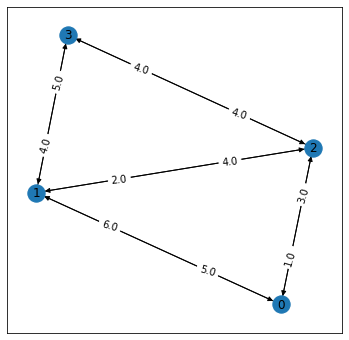

In [3]:
# From Params
#seed = 11
#n = 4
#np.random.seed(seed)
#D = np.random.randint(1, 7, size=(n,n))
#G = Network(n=n, seed=seed, D=D, p=0.7)
#G.setPhi(shortestPathsPhi(G))
#G.toPickle('4_node.pkl')

# From Pickle
G = netFromPickle('4_node.pkl')

G.visualize(withEdgeTraffic=True);
plt.gcf().set_size_inches(6, 6)

Next we run Gallagher's algorithm till it converges. We also visualize what the edge weights look like after Gallagher.

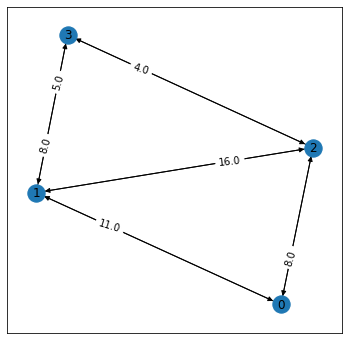

In [4]:
scores = iterGallagher(G, nTrials=100, eta=eta)
assert(convergenceConditions(G))
gallagher_best = G.D_T()
G.visualize(withEdgeTraffic=True);
plt.gcf().set_size_inches(6, 6)

In [5]:
x = np.arange(len(scores))
x_lim = [min(x) - 1, max(x) + 1]
y_lim = [min(scores) - 1, max(scores) + 1]

for i, s in enumerate(scores):
    plt.xlim(x_lim); plt.ylim(y_lim);
    plt.plot(x[:i+1], scores[:i+1], 'b-')
    plt.scatter([i], [s], c='r')
    plt.xlabel('# of iterations of Gallagher'); plt.ylabel('D_T (Expected delay)');
    plt.gcf().set_size_inches(6, 6)
    plt.savefig(os.path.join(savedir, f'{i}.jpg'))
    plt.gcf().clear()

<Figure size 432x432 with 0 Axes>

# Quadratic Relationship between Traffic and Delay on any Link

First we specify an Eta (a stepsize in the algorithm)

In [ ]:
eta = 0.01

Next we generate a Network by calling the Constructor. Here, however,
we specify custom D_func, and derivD_func, arguments to get a quadratic relationship between traffic and delay

In [ ]:
# From Params
seed = 11
n = 4
np.random.seed(seed)

# Set up quadratic relationship
D_scaling = np.random.randint(1, 7, size=(n,n))
D_func = lambda F: 1/2 * D_scaling * F ** 2
derivD_func = lambda F: D_scaling * F

G = Network(n=n, seed=seed, D_func=D_func, derivD_func=derivD_func, p=0.7)
G.setPhi(shortestPathsPhi(G))

G.visualize(withEdgeTraffic=True);
plt.gcf().set_size_inches(6, 6)

We next repeat all of the previous steps for the linear case

In [ ]:
scores = iterGallagher(G, eta=eta)
assert(convergenceConditions(G))
gallagher_best = G.D_T()
G.visualize(withEdgeTraffic=True);
plt.gcf().set_size_inches(6, 6)

In [ ]:
plt.plot(scores, 'b-', label='Gallagher iteration scores')
plt.xlabel('# of iterations of Gallagher'); plt.ylabel('D_T');
plt.title('Comparing Gallagher / other routing algorithms (Quadratic Traffic to Delay Relation)')
plt.gcf().set_size_inches(6, 6)
plt.legend();